# Nixtla - TimeGPT

## Imports

In [1]:
from nixtla import NixtlaClient
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime

In [3]:
ROUND_PREDICTIONS = False
SAVE_MODEL_TO_DISK = False
SAVE_DICT_TO_DISK = True
CURRENT_DATE = datetime.now().strftime("%d%m%Y_%H%M")
print("CURRENT_DATE", CURRENT_DATE)

CURRENT_DATE 29112024_1408


## API KEY

In [4]:
# Load environment variables from .env file
load_dotenv()

True

In [5]:
api_key = os.getenv("NIXTLA_API_KEY")

In [6]:
nixtla_client = NixtlaClient(
    api_key = api_key
)

In [7]:
nixtla_client.validate_api_key()

True

## Data

In [8]:
base_path = '..\\data\\top_10_crimes\\'

In [9]:
dist_ids = os.listdir(base_path)
dist_ids

['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']

In [10]:
cluster_names = os.listdir(os.path.join(base_path, dist_ids[0]))
print("num_cluster_names", len(cluster_names))

num_cluster_names 10


In [11]:
def load_crime_data(dist_id, offense, subset="train"):
    data_path = f"../data/top_10_crimes/{dist_id}/{offense}/{subset}.csv"
    crime_df = pd.read_csv(data_path, parse_dates=[0], index_col=0)
    return crime_df

In [12]:
crime_dist_dfs = {}
for i, dist_id in enumerate(dist_ids):
    crime_dist_dfs[dist_id] = {}
    for i, cluster_name in enumerate(cluster_names):
        train = load_crime_data(dist_id, cluster_name, subset="train")
        test = load_crime_data(dist_id, cluster_name, subset="test")
        
        # Save final dict
        crime_dist_dfs[dist_id][cluster_name] = {
            "train": train,
            "test": test
        }

In [13]:
print(f"districts in dict: {crime_dist_dfs.keys()}")
print(f"crimes in dict: {crime_dist_dfs["1.0"].keys()}")
print(f"test/train in dict: {crime_dist_dfs["1.0"]['Assault'].keys()}")

districts in dict: dict_keys(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0'])
crimes in dict: dict_keys(['Aggravated Assault', 'Assault', 'Auto Theft', 'Burglary', 'Domestic Assault', 'Domestic Violence', 'Property Damage', 'Sexual Assault', 'Shoplifting', 'Stolen Auto'])
test/train in dict: dict_keys(['train', 'test'])


In [14]:
crime_dist_dfs["1.0"]['Assault']["train"].head()

,Crime_Count
Reported_Date,
2015-01-05,5
2015-01-06,0
2015-01-07,0
2015-01-08,0
2015-01-09,0


> Reformat data

In [15]:
# Function to restructure the data
def restructure_for_forecasting(crime_dict):
    unique_id = 1
    for dist_id, crime_data in crime_dict.items():
        for cluster_name, df_types in crime_data.items():
            for df_type, df in df_types.items():
                # Reset index to make Reported_Date a column
                df = df.reset_index(names="Reported_Date")
                # Add unique_id column
                df['unique_id'] = unique_id
                # Rename columns
                df = df.rename(columns={"Reported_Date": "ds", "Crime_Count": "y"})
                # Ensure the date column is in datetime format
                df['ds'] = pd.to_datetime(df['ds'])
                # Reassign the processed dataframe back
                crime_dist_dfs[dist_id][cluster_name][df_type] = df
                unique_id+=1

# Apply the function
restructure_for_forecasting(crime_dist_dfs)

In [23]:
crime_dist_dfs["1.0"]['Assault']["train"].tail(10)

,ds,y,unique_id
3267,2023-12-16,0,3
3268,2023-12-17,0,3
3269,2023-12-18,0,3
3270,2023-12-19,0,3
3271,2023-12-20,2,3
3272,2023-12-21,0,3
3273,2023-12-22,0,3
3274,2023-12-23,0,3
3275,2023-12-24,0,3
3276,2023-12-25,2,3


## Start forecasting

In [24]:
timegpt_fcst_df = nixtla_client.forecast(df=crime_dist_dfs["1.0"]['Assault']["train"], h=len(crime_dist_dfs["1.0"]['Assault']["test"]), freq='D', time_col='ds', target_col='y', model='timegpt-1-long-horizon')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [25]:
timegpt_fcst_df.head()

,unique_id,ds,TimeGPT
0,3,2023-12-26,0.545688
1,3,2023-12-27,0.562861
2,3,2023-12-28,0.490824
3,3,2023-12-29,0.485257
4,3,2023-12-30,0.470092


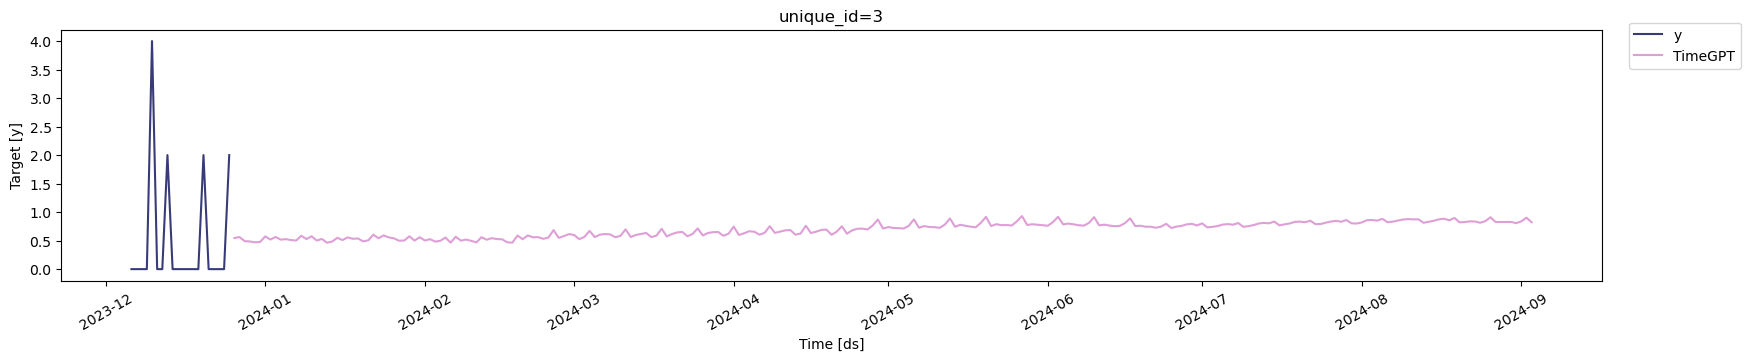

In [29]:
nixtla_client.plot(crime_dist_dfs["1.0"]['Assault']["train"].tail(20), timegpt_fcst_df, time_col='ds', target_col='y')

---